In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

FILE_PATH= "ML DATA-2.xlsx" # your file path

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

torch.manual_seed(23)
np.random.seed(23)

device = "cuda" if torch.cuda.is_available() else "cpu"

FILE = FILE_PATH
LR = 2e-3
EPOCHS_PER_SHEET = 1200


SiLU-> Sigmoid Linear Unit

SiLU(x)=x⋅σ(x)

We use SiLU instead of ReLU, as it works best for ODE Residual nn and its smoother than ReLU.

Benefits of SiLU over ReLU:

*   smoother derivatives
*   avoids dead neurons
*   more stable RK4 integration

Thus, SiLU is better than ReLU for our case.


Softplus(x)=ln(1+e^x)

Makes the output is smooth, continuous, differentiable.

Always produces a positive value which is perfect perfect for trainable physical parameters.

In [4]:
class HybridMIMO(nn.Module):
    def __init__(self):
        super().__init__()

        #Trainable cooling consts
        self.k1_raw= nn.Parameter(torch.tensor(0.1))
        self.k2_raw= nn.Parameter(torch.tensor(0.1))

        #heater gains
        self.a1_raw = nn.Parameter(torch.tensor(0.3))
        self.a2_raw= nn.Parameter(torch.tensor(0.25))

        #coupling gains
        self.c1_raw= nn.Parameter(torch.tensor(0.05))
        self.c2_raw= nn.Parameter(torch.tensor(0.05))
        #Residual nn
        self.res= nn.Sequential(
            nn.Linear(4,64),nn.SiLU(),
            nn.Linear(64,32),nn.SiLU(),
            nn.Linear(32,2)
        )

    def forward(self,T,H,Tenv):
        # Convert % to actual Watts
        P1= 0.9*(H[:,0]/100.0)
        P2= 0.9*(H[:,1]/100.0)

        k1= torch.nn.functional.softplus(self.k1_raw)
        k2= torch.nn.functional.softplus(self.k2_raw)

        a1= torch.nn.functional.softplus(self.a1_raw)
        a2= torch.nn.functional.softplus(self.a2_raw)

        c1= torch.nn.functional.softplus(self.c1_raw)
        c2= torch.nn.functional.softplus(self.c2_raw)

        #phy term
        dT_phys= torch.stack([-k1*(T[:,0]- Tenv[:,0])+ a1*P1+ c1*P2,-k2*(T[:,1]- Tenv[:,0])+ a2*P2+ c2*P1],dim=1)

        #residual term
        inp = torch.cat([T- Tenv,H/100.0],dim=1)
        dT_res= 0.5*self.res(inp)
        return dT_phys+dT_res


In [5]:
def rk4_step(model,T,H,Tenv,dt):
    k1= model(T,H,Tenv)
    k2= model(T+ 0.5*dt*k1,H,Tenv)
    k3= model(T+ 0.5*dt*k2,H,Tenv)
    k4= model(T+ dt*k3,H,Tenv)
    return T+ (dt/6)*(k1+ 2*k2+ 2*k3+ k4)


In [6]:
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 7.9 MB/s eta 0:00:00


In [7]:
model= HybridMIMO().to(device)
opt= optim.Adam(model.parameters(), lr=LR)
loss_fn= nn.MSELoss()

xls = pd.ExcelFile(FILE)
sheet_names = xls.sheet_names
sheet_loss_hist={}
# Skipping Sheet 3 and 4 as the data of this has either H1 and H2 is kept constant at 0.
for sheet in sheet_names:
    if (sheet=="Sheet3"):
        continue
    if (sheet=="Sheet4"):
        continue
    loss_hist=[]
    print("Training on:",sheet)
    print()

    df= pd.read_excel(FILE,sheet_name=sheet).dropna().sort_values("Time").reset_index(drop=True)

    T_env= df.loc[0,"T1"]

    Xs,Ys=[],[]

    for i in range(len(df)-1):
        t0= df.loc[i,"Time"]
        t1= df.loc[i+1,"Time"]
        dt= float(t1- t0)
        dt= max(dt,1.0)

        T0= [df.loc[i,"T1"],df.loc[i,"T2"]]
        T1= [df.loc[i+1,"T1"],df.loc[i+1,"T2"]]
        H = [df.loc[i,"H1"],df.loc[i,"H2"]]

        Xs.append([T0[0],T0[1],H[0],H[1],dt,T_env])
        Ys.append([T1[0],T1[1]])

    Xs= torch.tensor(Xs,dtype=torch.float32).to(device)
    Ys= torch.tensor(Ys,dtype=torch.float32).to(device)

    for ep in range(1,EPOCHS_PER_SHEET+1):
        T0= Xs[:,0:2]
        H = Xs[:,2:4]
        dt= Xs[:,4].unsqueeze(1)
        Tenv= Xs[:,5].unsqueeze(1)

        pred= rk4_step(model,T0,H,Tenv,dt)
        loss= loss_fn(pred,Ys)
        loss_hist.append(loss)
        opt.zero_grad()
        loss.backward()
        opt.step()

        if ep%50== 0:
            print(f"Epoch {ep}, Loss {loss.item():.6f}")

# if loss is not reduced properly

    if loss.item()>3:
        for ep in range(EPOCHS_PER_SHEET, EPOCHS_PER_SHEET+101):
            T0 = Xs[:,0:2]
            H  = Xs[:,2:4]
            dt = Xs[:,4].unsqueeze(1)
            Tenv = Xs[:,5].unsqueeze(1)

            pred = rk4_step(model, T0, H, Tenv, dt)
            loss = loss_fn(pred, Ys)
            loss_hist.append(loss)
            opt.zero_grad()
            loss.backward()
            opt.step()

            if ep % 50 == 0 or ep == 1:
                print(f" Epoch {ep}, Loss {loss.item():.6f}")
    sheet_loss_hist[sheet]= loss_hist

Training on: Sheet1

Epoch 50, Loss 4.834145
Epoch 100, Loss 3.130803
Epoch 150, Loss 3.044010
Epoch 200, Loss 3.011552
Epoch 250, Loss 2.993730
Epoch 300, Loss 2.979561
Epoch 350, Loss 2.968734
Epoch 400, Loss 2.958313
Epoch 450, Loss 2.947600
Epoch 500, Loss 2.936320
Epoch 550, Loss 2.924228
Epoch 600, Loss 2.911376
Epoch 650, Loss 2.897624
Epoch 700, Loss 2.882574
Epoch 750, Loss 2.865607
Epoch 800, Loss 2.846946
Epoch 850, Loss 2.825549
Epoch 900, Loss 2.799908
Epoch 950, Loss 2.768406
Epoch 1000, Loss 2.732213
Epoch 1050, Loss 2.690293
Epoch 1100, Loss 2.647165
Epoch 1150, Loss 2.584324
Epoch 1200, Loss 2.529457
Training on: Sheet2

Epoch 50, Loss 2.386514
Epoch 100, Loss 2.348026
Epoch 150, Loss 2.310966
Epoch 200, Loss 2.275284
Epoch 250, Loss 2.239896
Epoch 300, Loss 2.202605
Epoch 350, Loss 2.282912
Epoch 400, Loss 2.120764
Epoch 450, Loss 2.082222
Epoch 500, Loss 2.053268
Epoch 550, Loss 2.019896
Epoch 600, Loss 1.996190
Epoch 650, Loss 2.057796
Epoch 700, Loss 1.955165
Epoch

In [8]:
torch.save(model.state_dict(), "hybrid_mimo_model.pt")


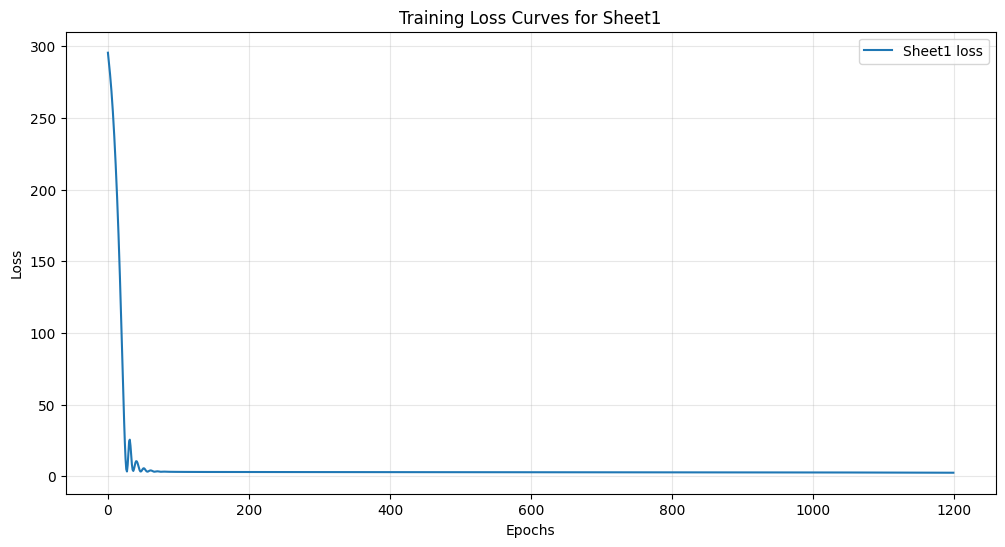

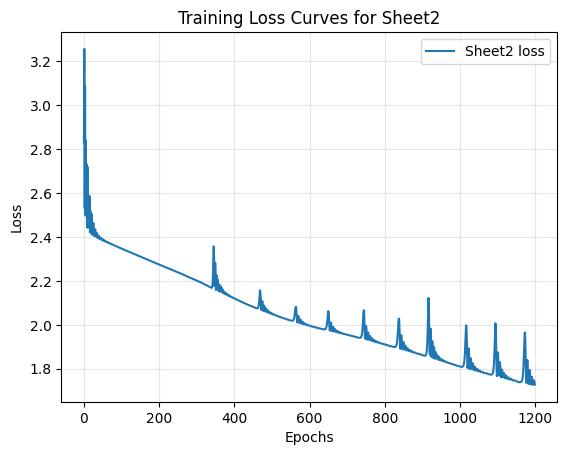

In [9]:
plt.figure(figsize=(12, 6))
for sheet, losses in sheet_loss_hist.items():
    plt.plot([loss.detach().cpu().numpy() for loss in losses], label=f"{sheet} loss")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Training Loss Curves for {sheet}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [10]:
def predict_after(T1,T2,H1,H2,t_sec,Tenv):
    dt= 1.0
    steps= int(t_sec/dt)

    T= torch.tensor([[T1,T2]],dtype=torch.float32,device=device)
    H= torch.tensor([[H1,H2]],dtype=torch.float32,device=device)
    Tenv= torch.tensor([[Tenv]],dtype=torch.float32,device=device)

    with torch.no_grad():
        for _ in range(steps):
            T= rk4_step(model,T,H,Tenv,dt)
            T= torch.maximum(T,Tenv)    # physics clamp (so that temp doesn't go below Tenv)

    return T.cpu().numpy()[0]

In [11]:
def simulate_pair(H1,H2):
    T1,T2= predict_after(26,26,H1,H2,60,26)
    return T1,T2

pairs=[
    (0,0),
    (10,0),
    (0,10),
    (30,30),
    (50,10),
    (100,100)
]

print("MIMO TEST")
for h1,h2 in pairs:
    T1,T2= simulate_pair(h1,h2)
    print(f"H1={h1} H2={h2}  Final: T1={T1:.2f}°C  T2={T2:.2f}°C")


MIMO TEST
H1=0 H2=0  Final: T1=26.00°C  T2=26.03°C
H1=10 H2=0  Final: T1=26.62°C  T2=26.00°C
H1=0 H2=10  Final: T1=26.64°C  T2=26.00°C
H1=30 H2=30  Final: T1=31.69°C  T2=30.14°C
H1=50 H2=10  Final: T1=31.61°C  T2=30.01°C
H1=100 H2=100  Final: T1=79.74°C  T2=65.71°C


In [12]:
print(predict_after(26,26, 10,10, 60, 26))

[27.154383 26.071451]


In [13]:
predict_after(26,26,10,0,20,26)


array([26.620758, 26.      ], dtype=float32)

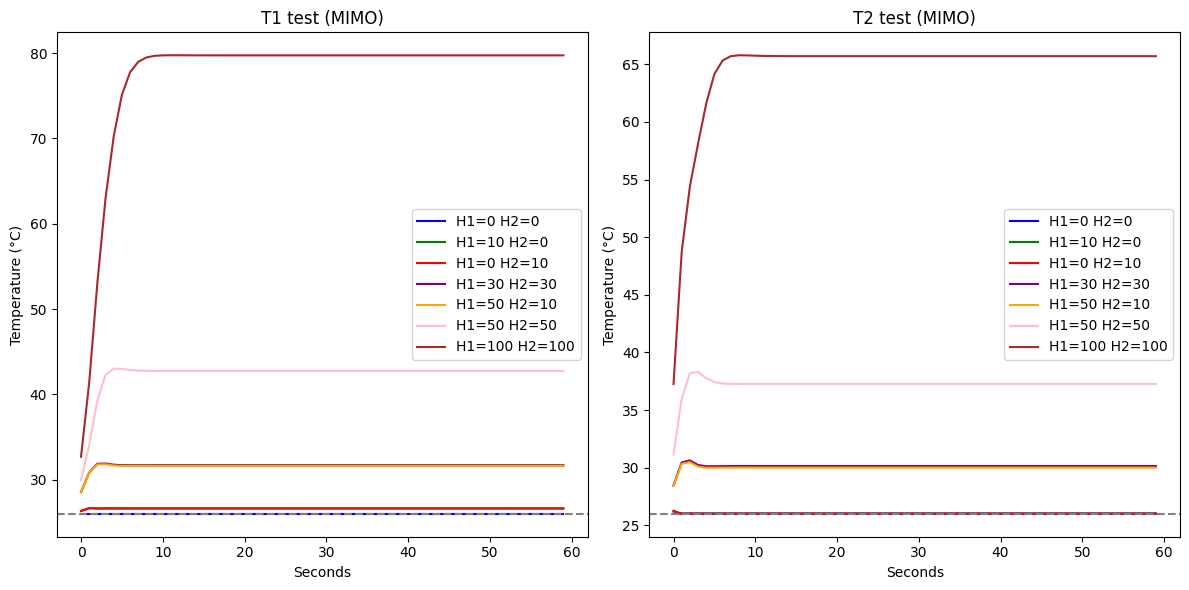

In [14]:
# func. test the model properly
def rollout_pair(T1,T2,H1,H2,T_env,duration=60,dt=1.0):
    steps= int(duration/dt)
    T1_list= []
    T2_list= []

    T= torch.tensor([[T1, T2]],dtype=torch.float32, device=device)
    H= torch.tensor([[H1, H2]],dtype=torch.float32, device=device)
    Tenv= torch.tensor([[T_env]],dtype=torch.float32, device=device)

    with torch.no_grad():
        for _ in range(steps):
            T= rk4_step(model,T,H,Tenv,dt)
            # no temperature below ambient
            T= torch.maximum(T,Tenv)
            T1_list.append(float(T[0,0].cpu()))
            T2_list.append(float(T[0,1].cpu()))

    return np.array(T1_list), np.array(T2_list)

#test cases
tests = [
    (0, 0),
    (10, 0),
    (0, 10),
    (30, 30),
    (50, 10),
    (50, 50),
    (100, 100)
]

T_env = 26
labels = ["H1=0 H2=0", "H1=10 H2=0", "H1=0 H2=10", "H1=30 H2=30", "H1=50 H2=10", "H1=50 H2=50", "H1=100 H2=100"]
colors = ["blue","green","red","purple","orange","pink","brown"]

plt.figure(figsize=(12,6))

#T1 graph
plt.subplot(1,2,1)
for (h1,h2),clr,lbl in zip(tests, colors, labels):
    T1_list,T2_list= rollout_pair(26,26,h1,h2,T_env)
    plt.plot(T1_list, color=clr, label=lbl)
plt.axhline(T_env, linestyle="--", color="gray")
plt.title("T1 test (MIMO)")
plt.xlabel("Seconds")
plt.ylabel("Temperature (°C)")
plt.legend()

#T2 graph
plt.subplot(1,2,2)
for (h1,h2),clr,lbl in zip(tests, colors, labels):
    T1_list, T2_list = rollout_pair(26,26,h1,h2,T_env)
    plt.plot(T2_list, color=clr, label=lbl)
plt.axhline(T_env, linestyle="--", color="gray")
plt.title("T2 test (MIMO)")
plt.xlabel("Seconds")
plt.ylabel("Temperature (°C)")
plt.legend()

plt.tight_layout()
plt.show()


## Observation:

the model is working as expected as the temp increases and then a slight decrease due to overshooting and then it remains constant.

The values of T2 are a smaller than T1 due to the heat distribution of H2 is more towards T1

In [15]:
# predict_after(T1,T2,H1,H2,t_sec,Tenv)

print(predict_after(26,26,0.4,0.4,25,27)+273.15)

[300.15    300.19714]


In [29]:
SETPOINT_C = np.array([40.0, 40.0]) # target temp for T1 and T2

In [30]:
def Plant(t, x, u):
    Tinf= 299.3693
    Cp= 500.0005
    As= 2e-4
    A= 10e-4
    m= 0.004
    U= 10.0009
    e= 0.9029
    BC= 5.67e-8

    dx1= (U*A*(Tinf-x[0]))+ (e*BC*A*(Tinf**4-x[0]**4))+ (U*As*(x[1]-x[0]))+ (e*BC*As*(x[1]**4-x[0]**4))+ u[0]
    dx2= (U*A*(Tinf-x[1]))+ (e*BC*A*(Tinf**4-x[1]**4))+ (U*As*(x[0]-x[1]))+ (e*BC*As*(x[0]**4-x[1]**4))+ u[1]

    return np.array([dx1, dx2])/(m*Cp)

def K2C(T_kelvin):
    return np.asarray(T_kelvin) - 273.15

def C2K(T_celsius):
    return np.asarray(T_celsius) + 273.15

def perc_to_watts(u_percent, H1_max=0.9, H2_max=0.9):
    u = np.asarray(u_percent, dtype=float)
    if u.ndim == 1:
        return np.array([u[0]/100.0 * H1_max, u[1]/100.0 * H2_max])
    else:
        return np.stack([u[:,0]/100.0 * H1_max, u[:,1]/100.0 * H2_max], axis=1)

In [31]:
#max watts
H1_max_W= 0.9
H2_max_W = 0.9
T_prediction = 40
T_control = 5           #control time
N= int(T_prediction/T_control)   # number of control steps
mpc_iters= 100          # number of MPC control iterations
opt_maxiter= 250       # optimizer iterations per MPC step


w_tracking = 50.0       # tracking error weight
w_move = 0.1            # control move penalty
w_overshoot = 100.0     #overshoot penalty

#T0
INITIAL_STATE_K = np.array([299.15, 299.15])

#Environment temperature
T_ENV_C = 26.0

def mpc_cost(U_flat, sp_C, N, x0_C, T_control, last_u_perc, Tenv_C):
    U = np.array(U_flat).reshape(N,2)

    xC = np.array(x0_C, dtype=float).copy()

    cost_track= 0.0
    cost_overshoot = 0.0

    for k in range(N):
        nextT = predict_after(
            float(xC[0]),           #T1
            float(xC[1]),           # T2
            float(U[k,0]),          # H1%
            float(U[k,1]),          # H2%
            float(T_control),       # time step
            float(Tenv_C)           # environment temp
        )
        xC = np.array(nextT, dtype=float)

        #Tracking error
        error= xC - sp_C
        cost_track+= w_tracking*np.sum(error**2)

        # COvershoot penalty
        overshoot = np.maximum(xC - sp_C, 0.0)
        cost_overshoot += w_overshoot * np.sum(overshoot**2)

    final_error = xC - sp_C
    cost_track += w_tracking * 10.0 * np.sum(final_error**2)

    #Penalize overshoot at final state heavily
    final_overshoot = np.maximum(xC - sp_C, 0.0)
    cost_overshoot += w_overshoot * 10.0 * np.sum(final_overshoot**2)

    #Penalty for erratic changes
    U_all = np.vstack([last_u_perc.reshape(1,2), U])
    du = np.diff(U_all, axis=0)
    cost_du = w_move * np.sum(du**2)

    avg_temp = np.mean(x0_C)
    if avg_temp > sp_C[0] - 2.0:  #if within 2°C of setpoint we want smaller and safer changes
        cost_effort = 0.01 * np.sum(U**2)
    else:
        cost_effort = 0.0001 * np.sum(U**2)

    total_cost = cost_track + cost_overshoot + cost_du + cost_effort

    return float(total_cost)


In [32]:
def run_mpc(iterations=mpc_iters,
            T_control=T_control,
            T_prediction=T_prediction,
            N=N,
            initial_state_K=INITIAL_STATE_K,
            setpoint_C=SETPOINT_C,
            Tenv_C=T_ENV_C,
            debug=False):

    x_plant_K = initial_state_K.copy()
    last_u_perc = np.array([0.0, 0.0])
    t_log = [0.0]
    x_log_K = [x_plant_K.copy()]
    u_log_perc = []
    cost_log = []

    u_guess = np.tile(np.array([50.0, 50.0]), (N,1)).flatten()
    bounds = [(0.0, 100.0)] * (2*N)

    print("STARTING MPC CONTROL LOOP")
    print(f"Initial state:T1={K2C(x_plant_K[0]):.2f}°C,T2={K2C(x_plant_K[1]):.2f}°C")
    print(f"Setpoint:T1={setpoint_C[0]:.2f}°C,T2={setpoint_C[1]:.2f}°C")
    print(f"Control interval:{T_control}s,Prediction horizon: {T_prediction}s (N={N})")
    print(f"Weights: tracking={w_tracking},move={w_move},overshoot={w_overshoot}")
    print()

    for it in range(iterations):
        u_watts = perc_to_watts(last_u_perc, H1_max_W, H2_max_W)
        # Plant simulation
        sol = solve_ivp(
            fun=lambda t, x: Plant(t, x, u_watts),
            t_span=[0.0, T_control],
            y0=x_plant_K,
            method='RK45',
            max_step=0.5
        )

        x_plant_K = sol.y[:, -1]
        t_log.append(t_log[-1] + T_control)
        x_log_K.append(x_plant_K.copy())
        #K to C for model
        x_plant_C = K2C(x_plant_K)

        error_C = x_plant_C - setpoint_C
        avg_error = np.mean(error_C)

        # initial guess:
        if avg_error < -5.0:   #If far below setpoint: use high heating
            u_init = np.array([70.0, 70.0])
        elif avg_error < -2.0:  # moderately below
            u_init = np.array([50.0, 50.0])
        elif avg_error < 0.5:  # slightly below or near
            u_init = np.array([30.0, 30.0])
        else:  # at or above setpoint:use low/zero heating
            u_init = np.array([10.0, 10.0])

        u_guess = np.tile(u_init, (N,1)).flatten()
        cost_before = mpc_cost(u_guess, setpoint_C, N, x_plant_C, T_control, last_u_perc, Tenv_C)

        res = minimize(
            fun=lambda U: mpc_cost(U, setpoint_C, N, x_plant_C, T_control, last_u_perc, Tenv_C),
            x0=u_guess,
            bounds=bounds,
            method="SLSQP",
            options={"maxiter": opt_maxiter, "ftol": 1e-6}
        )

        cost_after = res.fun
        cost_log.append(cost_after)

        # if debug and it < 5:
        #     print(f"  [DEBUG iter {it}] Cost: {cost_before:.2f} → {cost_after:.2f}, "
        #           f"Error: {avg_error:.2f}°C, u_init: [{u_init[0]:.1f}, {u_init[1]:.1f}]%")

        U_opt = res.x.reshape(N, 2)
        u_apply = U_opt[0].copy()
        u_apply = np.clip(u_apply, 0.0, 100.0)

        u_log_perc.append(u_apply.copy())

        if it % 5 == 0 or it < 3:
            error_norm = np.linalg.norm(x_plant_C - setpoint_C)
            overshoot_T1 = max(0, x_plant_C[0] - setpoint_C[0])
            overshoot_T2 = max(0, x_plant_C[1] - setpoint_C[1])
            print(f"Iter {it:3d} | t={t_log[-1]:6.1f}s | "
                  f"T1={x_plant_C[0]:5.2f}°C T2={x_plant_C[1]:5.2f}°C | "
                  f"H1={u_apply[0]:5.1f}% H2={u_apply[1]:5.1f}% | "
                  f"Error={error_norm:.3f}°C | "
                  f"Overshoot=[{overshoot_T1:.2f}, {overshoot_T2:.2f}]°C")

        # Updating for nxt iteration
        last_u_perc = u_apply.copy()
        u_guess = np.roll(res.x, -2)
        u_guess[-2:] = u_guess[-4:-2]
    t_log = np.array(t_log)
    x_log_K = np.vstack(x_log_K)
    u_log_perc = np.vstack(u_log_perc)
    cost_log = np.array(cost_log)

    return t_log, x_log_K, u_log_perc, cost_log


In [33]:
t_log, x_log_K, u_log_perc, cost_log = run_mpc(
    iterations=100,
    setpoint_C=SETPOINT_C,
    debug=False
)
x_log_C = K2C(x_log_K)
print(f"Final state: T1={x_log_C[-1,0]:.2f}°C, T2={x_log_C[-1,1]:.2f}°C")
print(f"Setpoint: T1={SETPOINT_C[0]:.2f}°C, T2={SETPOINT_C[1]:.2f}°C")
print(f"Final error:{np.linalg.norm(x_log_C[-1] - SETPOINT_C):.3f}°C")
print(f"Final control: H1={u_log_perc[-1,0]:.1f}%, H2={u_log_perc[-1,1]:.1f}%")
print(f"Control variation: H1 range [{u_log_perc[:,0].min():.1f}, {u_log_perc[:,0].max():.1f}]")
print(f"                   H2 range [{u_log_perc[:,1].min():.1f}, {u_log_perc[:,1].max():.1f}]")


STARTING MPC CONTROL LOOP
Initial state:T1=26.00°C,T2=26.00°C
Setpoint:T1=40.00°C,T2=40.00°C
Control interval:5s,Prediction horizon: 40s (N=8)
Weights: tracking=50.0,move=0.1,overshoot=100.0

Iter   0 | t=   5.0s | T1=26.01°C T2=26.01°C | H1=  5.1% H2=  5.1% | Error=19.787°C | Overshoot=[0.00, 0.00]°C
Iter   1 | t=  10.0s | T1=26.13°C T2=26.13°C | H1= 10.5% H2= 10.6% | Error=19.618°C | Overshoot=[0.00, 0.00]°C
Iter   2 | t=  15.0s | T1=26.36°C T2=26.37°C | H1= 14.9% H2= 14.9% | Error=19.283°C | Overshoot=[0.00, 0.00]°C
Iter   5 | t=  30.0s | T1=27.56°C T2=27.56°C | H1= 25.5% H2= 25.5% | Error=17.588°C | Overshoot=[0.00, 0.00]°C
Iter  10 | t=  55.0s | T1=30.39°C T2=30.16°C | H1= 28.4% H2= 24.9% | Error=13.760°C | Overshoot=[0.00, 0.00]°C
Iter  15 | t=  80.0s | T1=32.98°C T2=32.50°C | H1= 37.0% H2= 34.3% | Error=10.279°C | Overshoot=[0.00, 0.00]°C
Iter  20 | t= 105.0s | T1=35.73°C T2=35.13°C | H1= 41.3% H2= 39.2% | Error=6.478°C | Overshoot=[0.00, 0.00]°C
Iter  25 | t= 130.0s | T1=38.32°

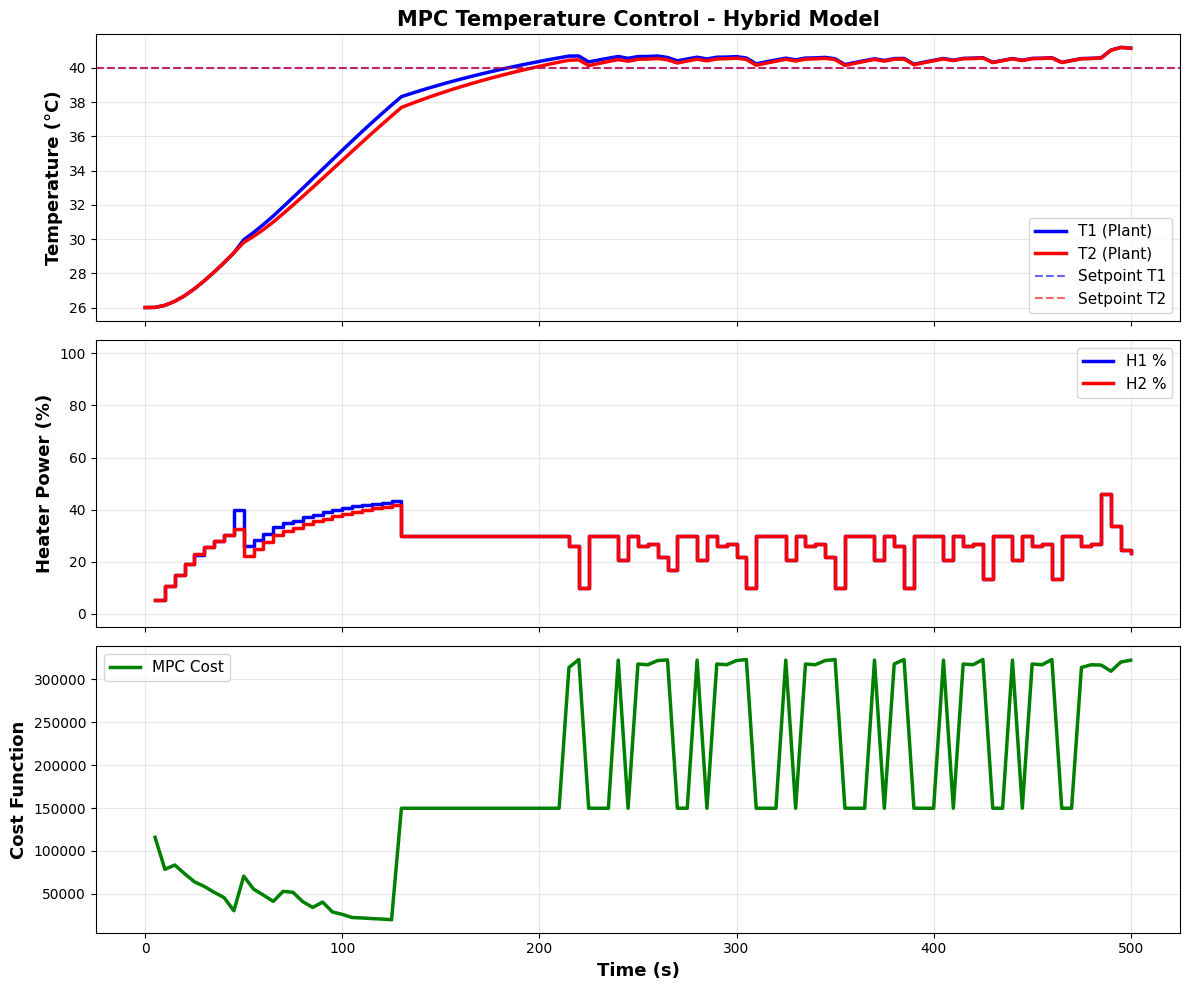

In [34]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

axes[0].plot(t_log, x_log_C[:,0], 'b-', linewidth=2.5, label='T1 (Plant)')
axes[0].plot(t_log, x_log_C[:,1], 'r-', linewidth=2.5, label='T2 (Plant)')
axes[0].axhline(SETPOINT_C[0], color='blue', linestyle='--',
                linewidth=1.5, alpha=0.6, label='Setpoint T1')
axes[0].axhline(SETPOINT_C[1], color='red', linestyle='--',
                linewidth=1.5, alpha=0.6, label='Setpoint T2')
axes[0].set_ylabel('Temperature (°C)', fontsize=13, fontweight='bold')
axes[0].legend(loc='best', fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_title('MPC Temperature Control - Hybrid Model',
                  fontsize=15, fontweight='bold')

t_controls = t_log[1:]
axes[1].step(t_controls, u_log_perc[:,0], 'b-', where='post',
             linewidth=2.5, label='H1 %')
axes[1].step(t_controls, u_log_perc[:,1], 'r-', where='post',
                 linewidth=2.5, label='H2 %')
axes[1].set_ylabel('Heater Power (%)', fontsize=13, fontweight='bold')
axes[1].legend(loc='best', fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([-5, 105])

axes[2].plot(t_controls, cost_log, 'g-', linewidth=2.5, label='MPC Cost')
axes[2].set_ylabel('Cost Function', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Time (s)', fontsize=13, fontweight='bold')
axes[2].legend(loc='best', fontsize=11)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [35]:

x_log_C = K2C(x_log_K)
errors = x_log_C - SETPOINT_C   # shape (T, 2)

# MAE and RMSE for each heater
MAE_T1 = np.mean(np.abs(errors[:,0]))
MAE_T2 = np.mean(np.abs(errors[:,1]))

RMSE_T1 = np.sqrt(np.mean(errors[:,0]**2))
RMSE_T2 = np.sqrt(np.mean(errors[:,1]**2))

print(f"MAE-T1  = {MAE_T1:.3f} °C")
print(f"MAE-T2  = {MAE_T2:.3f} °C")
print(f"RMSE-T1 = {RMSE_T1:.3f} °C")
print(f"RMSE-T2 = {RMSE_T2:.3f} °C")


MAE-T1  = 2.670 °C
MAE-T2  = 2.750 °C
RMSE-T1 = 4.870 °C
RMSE-T2 = 4.966 °C
